In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

## Minimum Variance Portfolio Backtest.

In [2]:
from qamsi.config.trading_config import TradingConfig
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from run import Dataset, initialize

In [3]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 30
ESTIMATION_WINDOW = 365

ESTIMATOR = CovEstimators.DNK.value(shrinkage_type="linear", window_size=365 * 20)

In [4]:
trading_config = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=2,
)

preprocessor, runner = initialize(
    dataset=DATASET,
    trading_config=trading_config,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [5]:
strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Computing Weights: 100%|██████████| 283/283 [00:12<00:00, 21.94it/s]


StrategyStatistics:
* final_nav = 10.111252
* geom_avg_total_r = 0.129403
* geom_avg_xs_r = 0.110106
* std_xs_r = 0.145333
* min_xs_r = -0.081885
* max_xs_r = 0.104457
* skew = 0.159030
* kurtosis = 15.613224
* max_dd = -0.274445
* sharpe = 0.757611
* alpha_buy_hold = 0.039518
* tracking_error_buy_hold = 0.140170
* ir_buy_hold = 0.281926
* factor_loadings = {'low_risk': 0.542109320860386, 'momentum': -0.08308304761490118, 'quality': 0.14225726428155938, 'size': 0.045810513850731364, 'value': -0.20206691021602036, 'spx': 0.736999366008258}
* alpha_benchmark = 0.038774
* alpha_benchmark_pvalue = 0.036552
* tracking_error_benchmark = 0.079053
* ir_benchmark = 0.490487
* ttest_pval = 0.349799
* levene_pval = 0.000000
* timing_ability_coef = -0.013793
* timing_ability_pval = 0.358998

In [6]:
result.std_xs_r, result.sharpe

(0.1453327267397476, 0.7576113945860214)

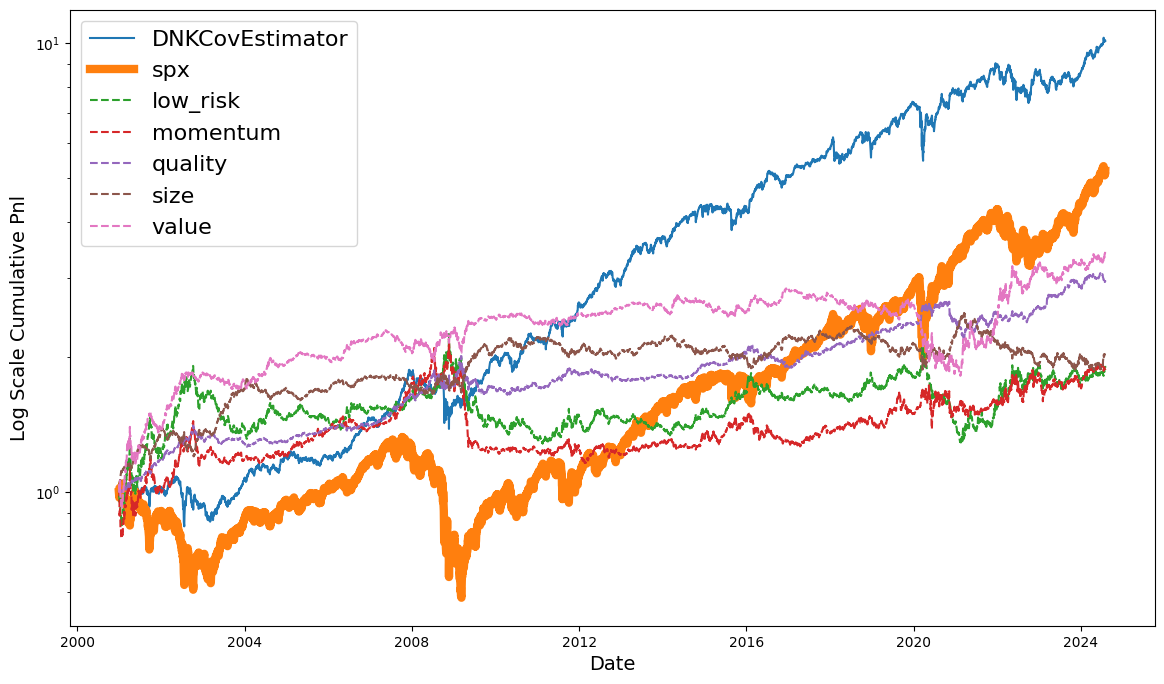

In [7]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

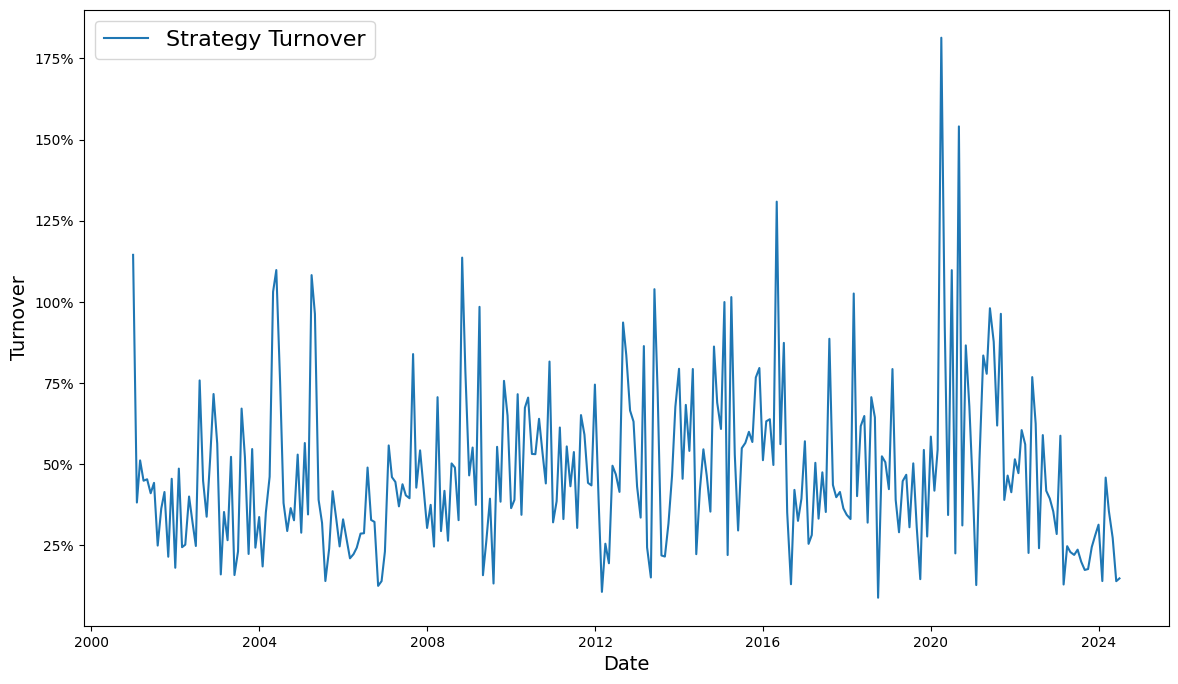

In [8]:
runner.plot_turnover()

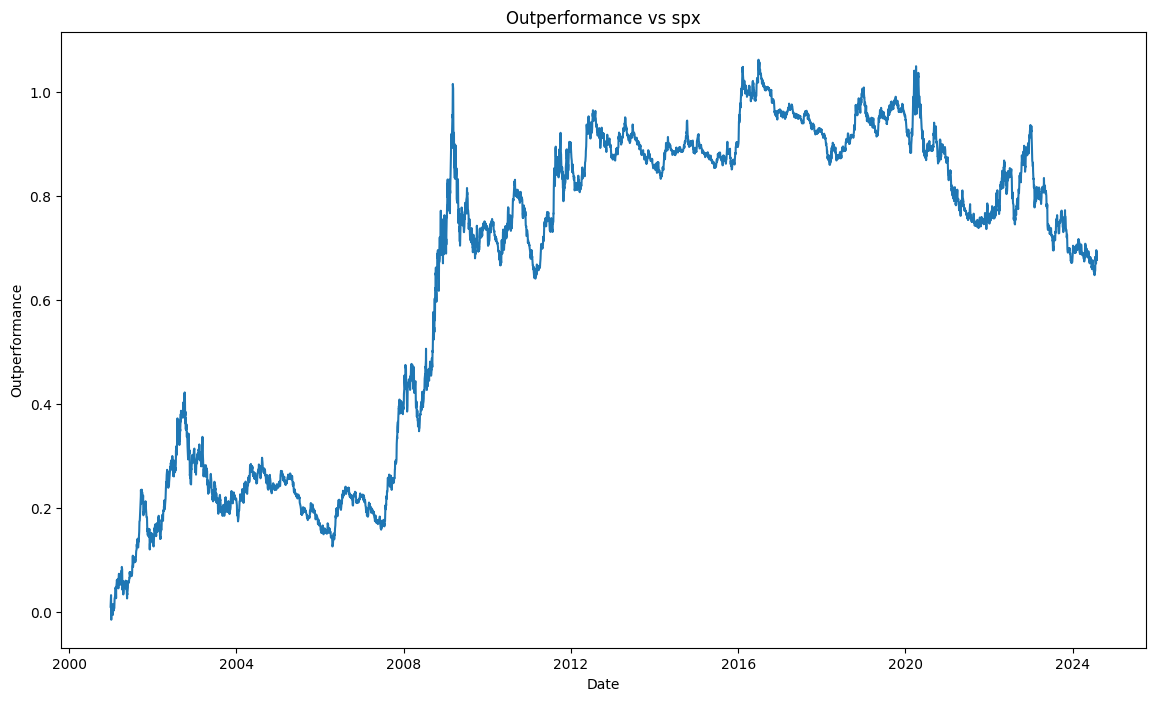

In [9]:
runner.plot_outperformance(mkt_only=True)

In [10]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

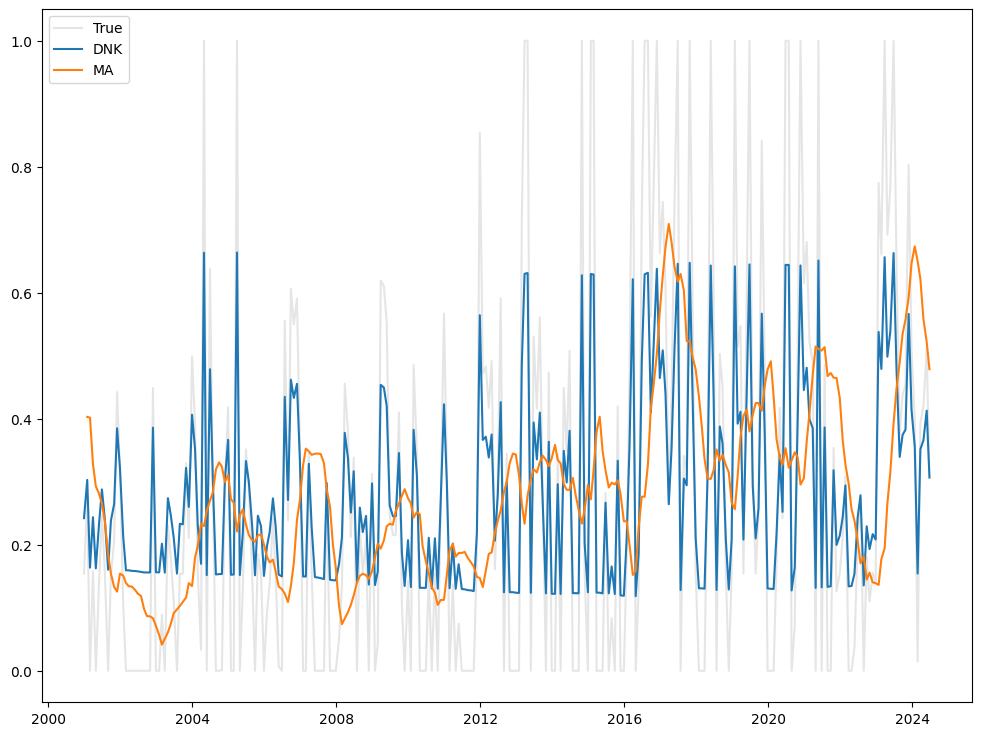

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

pred = ESTIMATOR.predictions

targets = runner.targets.loc[pred.index, "target"]
ma = runner.features.loc[pred.index, "target_rolling_mean"].shift(1)

plt.plot(
    targets.index,
    targets.to_numpy(),
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(pred.index, pred.to_numpy(), label="DNK")
plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(targets, pred)

0.12394434466089715